In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import mdct
import scipy.io.wavfile as wav
%matplotlib inline

## Loading and viz

In [2]:
rate, frames = wav.read("./mix.wav")
print(rate, frames.shape)

22050 (220501, 2)


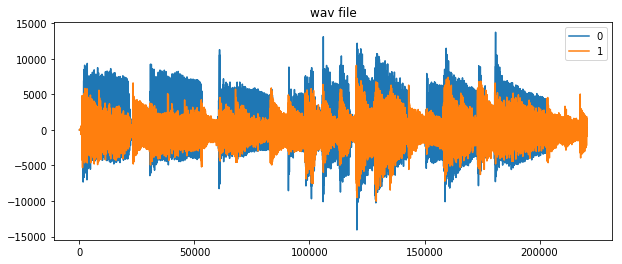

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(frames[:, 0], label=0)
plt.plot(frames[:, 1], label=1)
plt.title("wav file")
plt.legend()
plt.show()

## Listening

In [4]:
import IPython
IPython.display.Audio([frames[:, 0], frames[:, 1]], rate=rate)

We can hear three instruments; a bass (left), a guitar (right) and the piano (both).

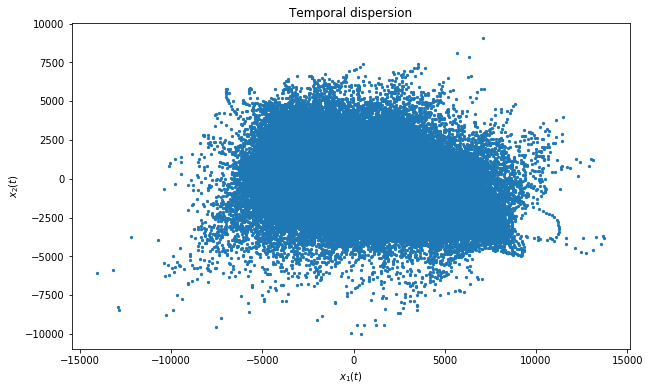

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(frames[:, 0], frames[:, 1], s=5)
plt.xlabel("$x_1(t)$")
plt.ylabel("$x_2(t)$")
plt.title("Temporal dispersion")
plt.show()

It is unclear how to distinguish the directions of the sources.

In [6]:
m = mdct.mdct(frames, window=ss.hann)
print(m.shape)

(512, 433, 2)


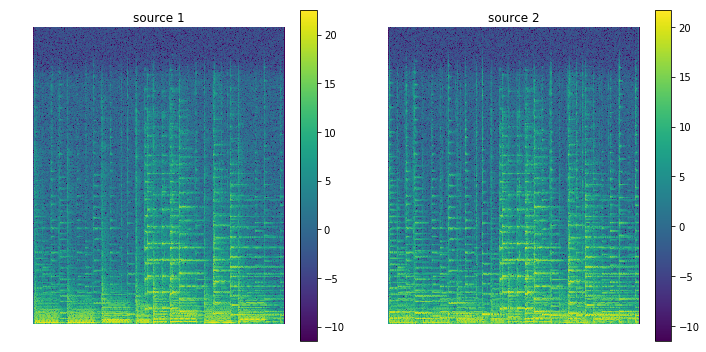

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(np.log(m[:, :, 0] ** 2 + 1e-5))
plt.axis("off")
plt.gca().invert_yaxis()
plt.title("source 1")
plt.colorbar()

plt.subplot(122)
plt.imshow(np.log(m[:, :, 1] ** 2 + 1e-5))
plt.axis("off")
plt.gca().invert_yaxis()
plt.title("source 2")
plt.colorbar()

plt.tight_layout()
plt.show()

Below the mdct transforms with differement window functions. The differences between them seem negligible.

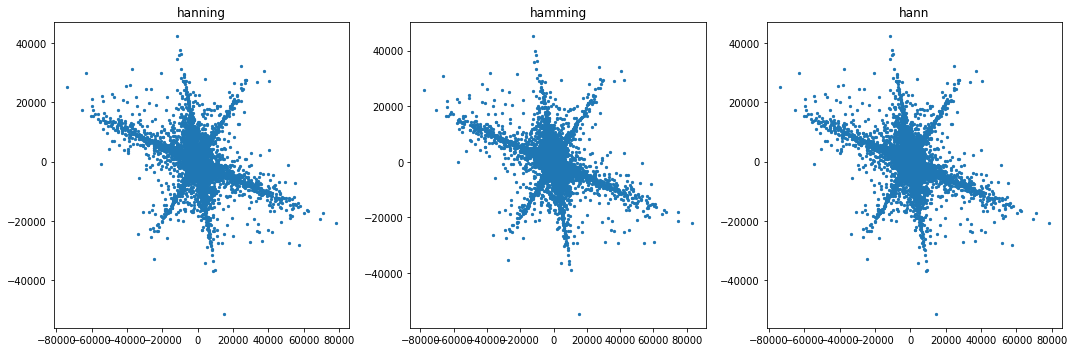

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
m = mdct.mdct(frames, window=ss.hanning)
plt.scatter(m[:, :, 0], m[:, :, 1], s=5)
plt.title("hanning")

m = mdct.mdct(frames, window=ss.hamming)
plt.subplot(132)
plt.scatter(m[:, :, 0], m[:, :, 1], s=5)
plt.title("hamming")

m = mdct.mdct(frames, window=ss.hann)
plt.subplot(133)
plt.scatter(m[:, :, 0], m[:, :, 1], s=5)
plt.title("hann")

plt.tight_layout()
plt.show()

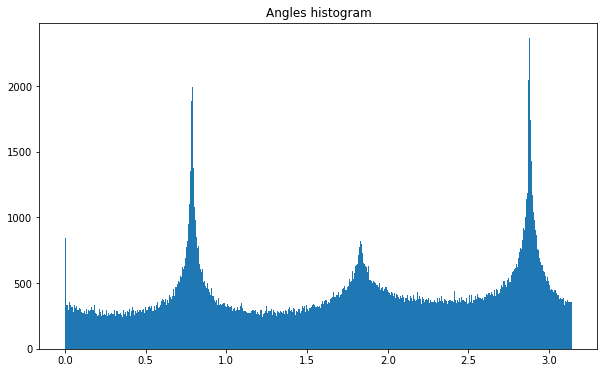

[0.78539239 2.87159093 2.87772681]
1.8284916593740557


In [9]:
angles = np.mod(np.arctan2(m[:, :, 0].ravel(), m[:, :, 1].ravel()), np.pi)

plt.figure(figsize=(10, 6))
n, b, _ = plt.hist(angles, bins=512)
plt.title("Angles histogram")
plt.show()

print(b[n.argsort()[-3:]])
# plt.plot(n); plt.show()
print(b[200 + n[200:400].argmax()])

Hence the $\theta_k$ are in $\{0.785, 1.828, 2.878\}$

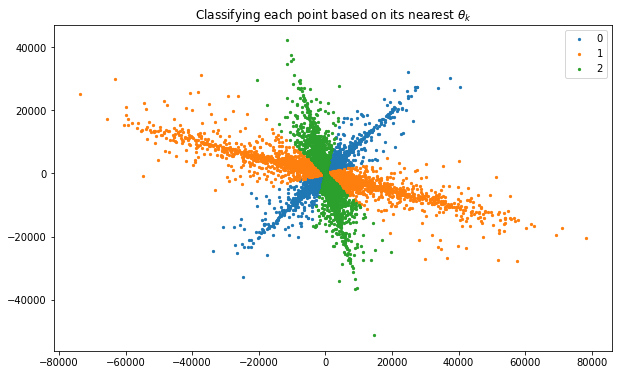

In [10]:
thetas = np.array([0.7854, 1.8284, 2.8778])
classd = np.abs(np.sin(angles - thetas.reshape(-1, 1))).argmin(0).reshape(512, -1)

plt.figure(figsize=(10, 6))

xx0, yy0 = np.where(classd == 0)
plt.scatter(m[xx0, yy0, 0], m[xx0, yy0, 1], s=5, label=0)
xx1, yy1 = np.where(classd == 1)
plt.scatter(m[xx1, yy1, 0], m[xx1, yy1, 1], s=5, label=1)
xx2, yy2 = np.where(classd == 2)
plt.scatter(m[xx2, yy2, 0], m[xx2, yy2, 1], s=5, label=2)

plt.title("Classifying each point based on its nearest $ \\theta_k $")
plt.legend()
plt.show()

### Reconstruction with inverse MDCT

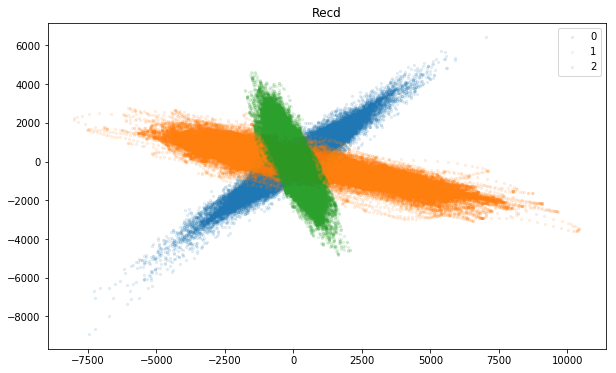

In [11]:
plt.figure(figsize=(10, 6))

sources = list()
for i in range(3):
    Y = np.zeros((512, 433, 2))
    Y[classd == i] = m[classd == i]
    y = mdct.imdct(Y)
    y = y.reshape(512, -1, 2)

    plt.scatter(y[:, :, 0], y[:, :, 1], s=5, alpha=.1, label=i)
    sources.append(y)
    
plt.title("Recd")
plt.legend()
plt.show()

In the cell below we can hear the reconstructed sounds. They are quite good except for some low amplitude noise that we can hear in some more than in the others (quite high for the bass reconstruction, lower for the piano).

- `src = 0`: piano
- `src = 1`: bass
- `src = 2`: guitar

In [12]:
src = 2
recdFrames = sources[src].reshape(-1, 2)
IPython.display.Audio([recdFrames[:, 0], recdFrames[:, 1]], rate=rate)

### MMSE estimation

Model is $ y(f,n) = B(f, n)\cdot x(f,n) $ with $B(f,n) \in \mathbb C^{K,M}$.
MMSE is $B$ minimizing $\mathbb E[||y-s||^2]$, and we have

$$ B(f,n) = R_{sx}(f, n) R_{xx}(f,n)^{-1} $$

with: 

- $R_{sx} = R_{ss}\cdot A^H$, $A$ the source mixing model and $A^H = \bar{H^t}$ its hermitian conjugate
- $R_{xx} = A \cdot R_{ss} \cdot A^H$
- $R_{ss}(\tau) = \mathbb E[s(t+\tau)\cdot s(t)^t]$

Practically, we'll compute 

$$ B = R_{ss} \cdot A^H \cdot (A\cdot R_{ss}\cdot (A^H)^{-1}) $$

Hence we need to provide an estimation of $A \in \mathbb R ^{K\times M}$.

In the following cell we introduce the $T\times K \times M$ tensor `a` which compiles all frequencies of the reconstructed sources

In [77]:
a = np.vstack([s.reshape(1, -1, 2) for s in sources])
a = np.rollaxis(a, 1, 0)
print(a.shape)

herm_conj = np.ones((3, 2))
herm_conj[:, 1] *= -1
ah = np.array([(at * herm_conj).T for at in a])
print(ah.shape)

(221184, 3, 2)
(221184, 2, 3)


In [73]:
rss = np.array([np.outer(a[t], a[t]) for t in range(a.shape[0])])

In [76]:
np.round(rss.mean(0))

array([[  492002.,   460787.,        0.,       -0.,        0.,        0.],
       [  460787.,   475362.,        0.,        0.,        0.,        0.],
       [       0.,        0.,  4432240., -1223246.,        0.,       -0.],
       [      -0.,        0., -1223246.,   417302.,       -0.,        0.],
       [       0.,        0.,        0.,       -0.,   119784.,  -271602.],
       [       0.,        0.,       -0.,        0.,  -271602.,   903146.]])